Lagrangian Tracer Bloom Model
==

Based on v00, not clear exactly what has changed aside from pointing to bloom_tracers_v01
rather than bloom_tracers_v09.

Later updated to point to newer bloom_tracers_v09 run.

In [1]:
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")
from stompy import utils
import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
from stompy.plot import plot_utils, plot_wkb
from stompy.grid import unstructured_grid
from matplotlib import colors
import pandas as pd
import os
import numpy as np
import xarray as xr
import subprocess
from scipy.integrate import solve_ivp
from numba import njit

from IPython.display import Video
import time
import six
import datetime
import glob
from stompy.plot import nbviz

In [3]:
# These online-coupled dfm-dwaq runs.

# Spinup
#run_dir="bloom_tracers_v01/run_20220801T0000_20220804T0000_v01"
# Main run
#run_dir="bloom_tracers_v01/run_20220804T0000_20220830T0000_v00"

# 2024-06-28: improved temperature field, 3 choices of swimming
run_dir="bloom_tracers_v09/run_20220804T1820_20220830T0000_v01"
swim_speeds=[5,10,0]

model=dfm.DFlowModel.load(run_dir)

In [4]:
ds=model.map_dataset()

In [5]:
ds.reload()

In [6]:
grid=ds.grid
grid_poly=grid.boundary_polygon()

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
/richmondvol1/rusty/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3212664407.249223, 15 potential interiors


In [7]:
def ratio(a,b,b_min=1e-8):
    a_b = a/b.clip(b_min)
    # avoid using np.where, since it loses xarray dimensions.
    a_b[b<b_min] = np.nan
    return a_b

In [8]:
frac=0.1
M=grid.smooth_matrix()
def fill(values,iterations=50):
    valid=np.isfinite(values)
    data=np.where(valid,values,0.0)
    weight=np.where(valid,1,0.0)
    for _ in range(iterations):
        data=M.dot(data)
        weight=M.dot(weight)
        data[valid]=values[valid]
        weight[valid]=1.0
    result=np.full(len(values),np.nan)
    valid=weight>1e-4
    result[valid]=data[valid]/weight[valid]
    return result

INFO:utils:83181/86633


Checking swim results
--

Looks like setting swimming via DFM is working, and the age/depth/radiation tracers
give reasonable results.

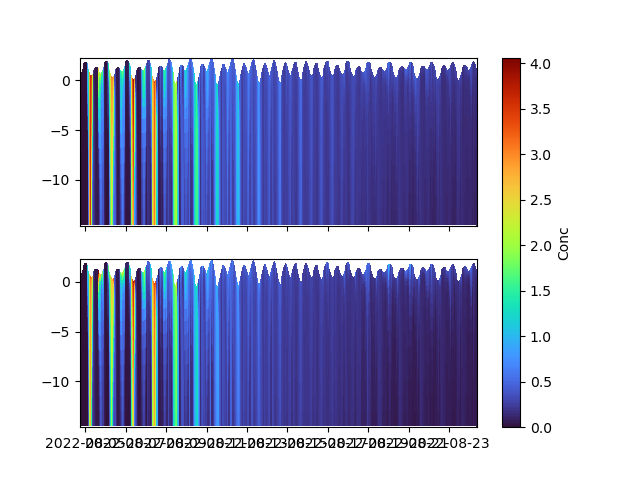

In [9]:
# Check to see whether upward swimming is working, and if age/property tracers are working.
point=[557240,4185530] # SE of Treasure Island.
c=ds.grid.select_cells_nearest(point)

conc0_tz = ds['conc0'].isel(nFlowElem=c)
conc1_tz = ds['conc1'].isel(nFlowElem=c)
z=-ds['FlowElem_zcc'].isel(nFlowElem=c) + ds['LayCoord_cc'] * ds['waterdepth'].isel(nFlowElem=c)

fig,axs=plt.subplots(2,1,sharex=True,sharey=True)
colls=[]
for ax,conc in zip(axs,[conc0_tz,conc1_tz]):
    colls.append( plot_utils.pad_pcolormesh( conc.time, z, conc.values.T, cmap='turbo', shading='flat', ax=ax) )
colls[0].set_clim( colls[1].get_clim() )
plt.colorbar( colls[0], ax=axs, label="Conc")

(557539.5016976751, 568625.700970802, 4174855.5064838855, 4184429.951310677)

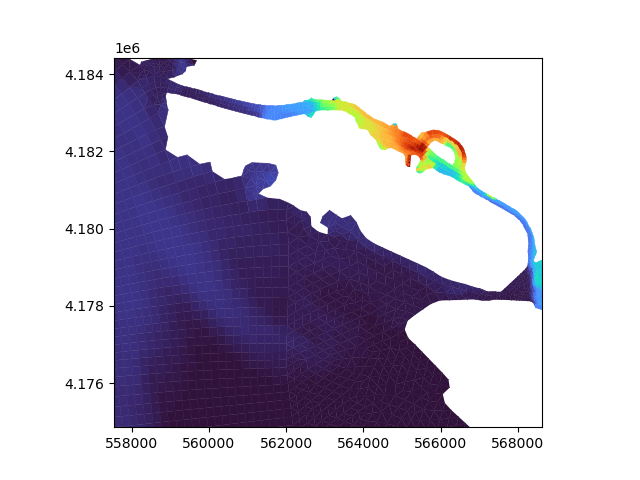

In [10]:
# temporary plot to see if agec is doing anything
fig,ax=plt.subplots()

# conc0: fine
# agec0: nothing.
# radc0: nothing
# radc1, radc2: nothing.
scal=ds['radc0'].isel(time=200,laydim=15).values
ds.grid.plot_cells(values=scal,cmap='turbo',ax=ax,lw=0.4,ec='face')
ax.axis((557539.5016976751, 568625.700970802, 4174855.5064838855, 4184429.951310677))

In [12]:
# Similar, but check on age
# v09: no age process?
if 0:
    if 'agec0' in ds:
        agec0 = ds['agec0'].isel(nFlowElem=c)
        conc0 = ds['conc0'].isel(nFlowElem=c)
        age0=ratio(agec0, conc0, 1e-5)
        ages=[age0]
    
        z=-ds['FlowElem_zcc'].isel(nFlowElem=c) + ds['LayCoord_cc'] * ds['waterdepth'].isel(nFlowElem=c)
        
        if 'agec1' in ds:
            agec1 = ds['agec1'].isel(nFlowElem=c)
            age1=ratio(agec1, conc1_tz, 1e-5)
            ages.append(age1)
            
        fig,axs=plt.subplots(len(ages),1,sharex=True,sharey=True,squeeze=False)
        colls=[]
        for ax,age in zip(axs[:,0],ages):
            colls.append( plot_utils.pad_pcolormesh( ds.time, z, age.values.T, cmap='turbo', shading='flat',ax=ax) )
            if len(colls)>1:
                colls[-1].set_clim( colls[0].get_clim() )
        plt.colorbar( colls[0], ax=axs, label="age")
    else:
        print("This run doesn't have age")

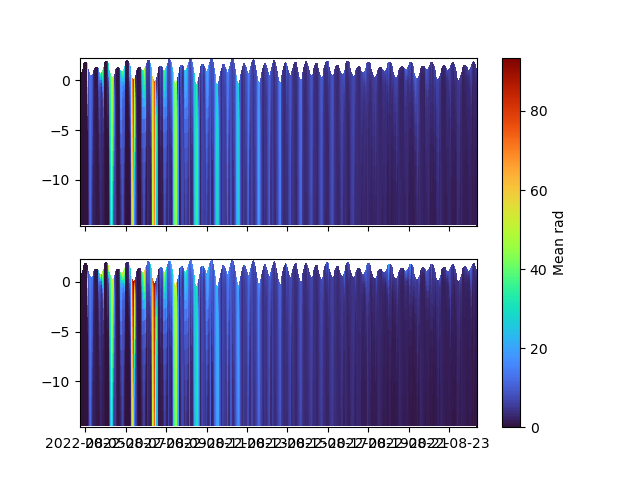

In [13]:
# Similar, but check on rad.
radc0 = ds['radc0'].isel(nFlowElem=c)
radc1 = ds['radc1'].isel(nFlowElem=c)
z=-ds['FlowElem_zcc'].isel(nFlowElem=c) + ds['LayCoord_cc'] * ds['waterdepth'].isel(nFlowElem=c)

age_exact = ((ds.time - ds.time.values[0]) / np.timedelta64(86400,'s'))
rad0=ratio(radc0, age_exact, 1e-5)
rad1=ratio(radc1, age_exact, 1e-5)

fig,axs=plt.subplots(2,1,sharex=True,sharey=True)
colls=[]
for ax,rad in zip(axs,[rad0,rad1]):
    colls.append( plot_utils.pad_pcolormesh( ds.time, z, rad.values.T, cmap='turbo', shading='flat',ax=ax) )
colls[0].set_clim( colls[1].get_clim() )
plt.colorbar( colls[0], ax=axs, label="Mean rad")

In [14]:
# Lastly, mean depth
if 'depc0' in ds:
    depc0 = ds['depc0'].isel(nFlowElem=c)
    depc1 = ds['depc1'].isel(nFlowElem=c)
    
    dep0=ratio(depc0, agec0, 1e-5)
    dep1=ratio(depc1, agec1, 1e-5)
    
    fig,axs=plt.subplots(2,1,sharex=True,sharey=True)
    colls=[]
    for ax,dep in zip(axs,[dep0,dep1]):
        colls.append( ax.pcolormesh( ds.time, z, dep.values.T, cmap='turbo', shading='nearest') )
    colls[0].set_clim( colls[1].get_clim() )
    plt.colorbar( colls[0], ax=axs, label="Mean depth")

Plotting All Fields
--

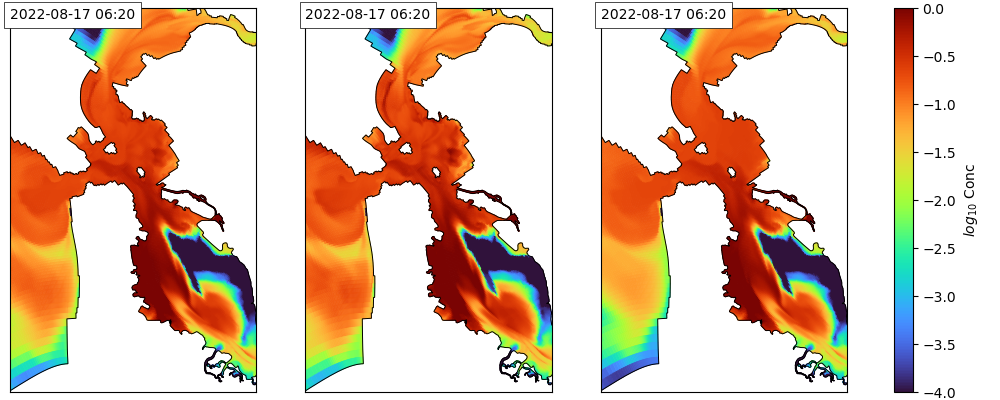

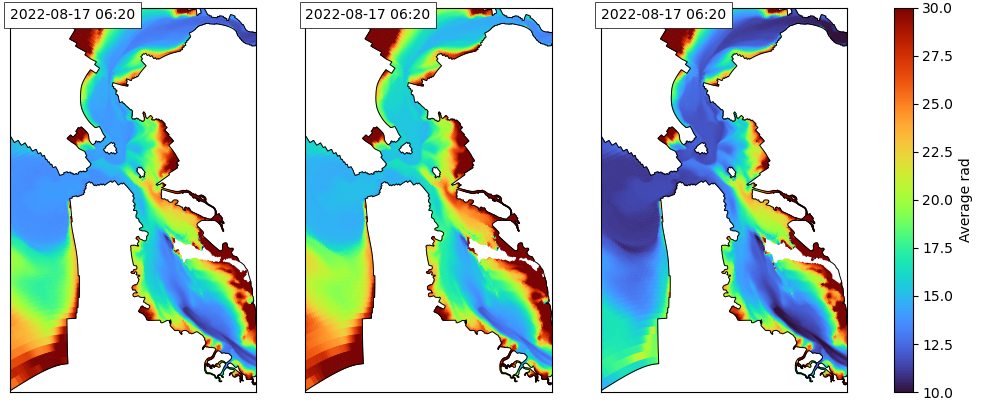

In [105]:
tidx=300

def rad_fn(snap,g):
    return property_fn(snap,g,'radc')
def dep_fn(snap,g):
    return property_fn(snap,g,'radc')

def snap_t(snap):
    return (snap.time - ds.time.isel(time=0))/np.timedelta64(86400,'s')
    
def property_fn(snap,g,property):
    v=f'agec{g}'
    if v in snap:
        return ratio( snap[f'{property}{g}'].compute(), snap[v].compute(), 1e-5)
    else:
        return ratio( snap[f'{property}{g}'], snap[f'conc{g}']*snap_t(snap), 1e-5)

def age_fn(snap,g):
    v=f'agec{g}'
    if v in snap:
        return ratio(snap[f'agec{g}'].values, snap[f'conc{g}'].values,1e-5)
    else:
        return 0*snap[f'conc{g}'] + snap_t(snap)

plots=[
    dict(label='$log_{10}$ Conc', clim=[-4,0], data_fn=lambda snap,g: np.log10(snap[f'conc{g}'].values.clip(1e-4))),
    dict(label='Average rad', clim=[10,30],data_fn=rad_fn),
    #dict(label="Depth exposure (m)", clim=[0,10], data_fn=dep_fn),    
    #dict(label="Age (d)", clim=[0,15], data_fn=age_fn),         
]


snap2d=ds.isel(time=tidx,laydim=-1)

for plot in plots: 
    fig,axs=plt.subplots(1,3,figsize=(10,4))
    for g,ax in enumerate(axs):
        ax.set_adjustable('datalim')
        fig.subplots_adjust(left=0.01, right=0.94, top=0.98, bottom=0.02)
        ax.xaxis.set_visible(0)
        ax.yaxis.set_visible(0)    
        kw=dict(lw=0.5,edgecolor='face', cmap='turbo')    
        scal=plot['data_fn'](snap2d,g) 
                
        ccoll=ds.grid.plot_cells( values=scal, clim=plot['clim'], ax=ax, **kw)
        plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,ax=ax)
        ax.axis((532541.1781775085, 575394.0337062994, 4160999.923094737, 4202393.6312130485))
        ax.text(0.0,1.0, utils.strftime(snap2d.time.values), transform=ax.transAxes,va='top',
                bbox=dict(fc='w', ec='k',lw=0.5))
    plt.colorbar(ccoll,label=plot['label'],ax=axs,fraction=0.05)


In [99]:
from stompy import memoize

@memoize.memoize(lru=1)
def extract_tracers(tidx,layer,Isat=10.0,thresh=1e-5,group=0):
    # Extraction
    # instantaneous release, so age is a given.
    t=ds.time.isel(time=tidx).values
    age_d = (t - ds.time.values[0]) / np.timedelta64(86400,'s')
    
    if layer=='mean':
        snap=ds.isel(time=tidx)
        conc = snap[f'conc{group}'].values.mean(axis=1).clip(0,np.inf)

        # These should be about the same, not sure why one would be preferable over the
        # other.
        #Imean =  ratio( snap['radc0'].values, snap['agec0'].values, thresh)
        Imean = ratio( snap[f'radc{group}'].values, snap[f'conc{group}'].values*age_d, thresh)
            
        kLight = (Imean/(Imean + Isat)).mean(axis=1) # happen to know that layer is the second dimension    
    else:
        snap=ds.isel(time=tidx,laydim=layer)
        conc  = snap[f'conc{group}'].values
    
        # average irradiance accounting for Kd, vertical mixing.
        Imean = ratio( snap[f'radc{group}'].values, snap[f'conc{group}'].values*age_d, thresh)
        # This could be averaged over the layers instead.
        kLight = Imean/(Imean + Isat)

    #Imean[np.isnan(Imean)]=0.0 
    #kLight = fill(kLight, iterations=120)
    print(f"kLight: {np.isnan(kLight).sum()} missing values, thresh={thresh}")
    return dict(age_d=age_d, conc=conc, kLight=kLight, Imean=Imean, t=t)  


In [93]:
sample_xy = [561890, 4173260]
sample_c=ds.grid.select_cells_nearest(sample_xy) # 24893

In [102]:
# Panel for P and a panel for N.

def solveNP(thresh=1e-5,
            # Parameters:
            c0 = 50,
            tidx = 20, 
            Isat=20., 
            N0=35, # initial DIN
            Nsat=0.5,
            kprod=0.7, # per day. high!
            kmort=0.1,
            alpha=0.15, # stoichiometry, uM DIN per ug/l chl production.
            layer='mean',
            group=0):
    tracers=extract_tracers(tidx=tidx, layer=layer, Isat=Isat, thresh=thresh, group=group)
    kLight = tracers['kLight']
    conc = c0*tracers['conc']
    age_d = tracers['age_d']
    Imean = tracers['Imean']
    t = tracers['t']

    sel = np.isfinite(kLight * conc * age_d)
    kLight = kLight[sel]
        
    # ODE integration
    # State vector is [ P[0].... P[i], N[0], ... , N[i] ]
    def diff(t,state):
        P,N=state.reshape([2,-1])
        N=N.clip(0) # no evidence this is really necessary
        P=P.clip(0) # likewise.
        kDIN=N/(N+Nsat)
        dgrossP = kprod*kLight*kDIN*P
        dnetP = -kmort*P + dgrossP
        dN = -alpha*dgrossP
        mu_net = kprod*kLight*kDIN - kmort
        return np.r_[dnetP,dN]
    IC=np.r_[conc[sel], N0*np.ones_like(conc)[sel]]

    print("IC shape: ", IC.shape) # 2*Ncells
    
    # odeint was buggy.
    #result = odeint(diff, IC, [0,age_d], hmax=0.1)
    bunch = solve_ivp(diff, y0=IC, t_span=[0,age_d])
    result=bunch.y[:,-1]
    Psel,Nsel = result.reshape([2,-1])
    # expand
    if 0:
        # assume no biomass, no depletion of N when conc too small.
        P = np.full(conc.shape,0.0)
        N = np.full(conc.shape,N0)
    else:
        # Make it clear where data is missing
        P = np.full(conc.shape,np.nan)
        N = np.full(conc.shape,np.nan)
        
    P[sel]=Psel
    N[sel]=Nsel
    
    ds=xr.Dataset()
    ds['N'] = ('cell',), N
    ds['P'] = ('cell',), P
    ds['time'] = (),t
    return ds

kLight: 16725 missing values, thresh=0.1
IC shape:  (66542,)
kLight: 17217 missing values, thresh=0.1
IC shape:  (65558,)


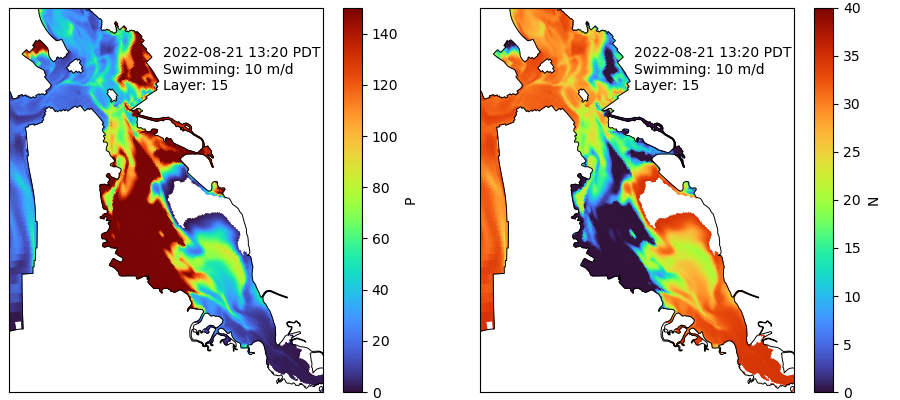

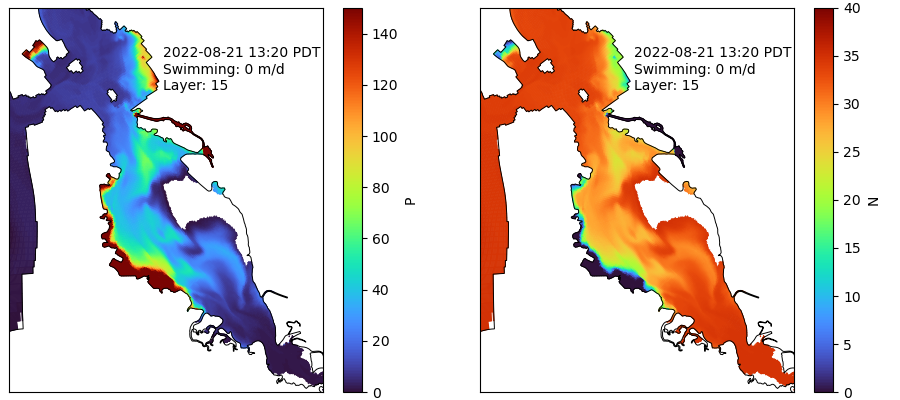

In [103]:
import matplotlib.colorbar as cbar

tidx=97-24 # 8/7 noon
tidx=98+13*24

for group in [1,2]: # [2,0,1]:
    for layer in [15]:
        result = solveNP(c0=1.0, tidx=tidx,group=group,layer=layer, kprod=0.7, kmort=0.05,
                         thresh=1e-1)
        
        fig,axs=plt.subplots(1,2,figsize=(9,4))
        fig.subplots_adjust(left=0.01, right=0.97, top=0.98, bottom=0.02)
        axP,axN = axs
        caxs=[cbar.make_axes(ax)[0] for ax in axs]
        
        kw=dict(lw=0.5,edgecolor='face', cmap='turbo')
        
        for ax,cax,plot in zip(axs,caxs,[
            dict(scal=result.P,label='P',clim=[0,150]),
            dict(scal=result.N,label='N',clim=[0,40])
        ]):
            ax.set_adjustable('datalim')
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)    
            ccoll=ds.grid.plot_cells( values=plot['scal'], ax=ax,**kw)
            ccoll.set_clim(plot['clim'])
            plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,ax=ax)
            plt.colorbar(ccoll,label=plot['label'],cax=cax)
            # ax.axis((532541.1781775085, 575394.0337062994, 4160999.923094737, 4202393.6312130485))
            ax.axis((540604.0430344798, 585428.0850690929, 4144192.2487012795, 4198977.188965806))
            txt="\n".join([utils.strftime(result.time-np.timedelta64(7,'h'))+" PDT",
                           f"Swimming: {swim_speeds[group]} m/d",
                           f"Layer: {layer}"])
            ax.text(0.49,0.9, txt, va='top',
                    transform=ax.transAxes)

IC shape:  (46856,)
IC shape:  (45618,)
IC shape:  (44454,)
IC shape:  (43496,)
IC shape:  (43004,)
IC shape:  (42974,)
IC shape:  (43420,)
IC shape:  (43892,)
IC shape:  (44840,)
IC shape:  (45816,)
IC shape:  (46654,)
IC shape:  (47456,)
IC shape:  (47808,)
IC shape:  (47468,)
IC shape:  (46732,)
IC shape:  (46136,)
IC shape:  (45792,)
IC shape:  (46066,)
IC shape:  (46532,)
IC shape:  (47354,)
IC shape:  (49148,)
IC shape:  (50942,)
IC shape:  (51944,)
IC shape:  (52064,)
IC shape:  (51296,)
IC shape:  (50036,)
IC shape:  (48906,)
IC shape:  (46982,)
IC shape:  (45834,)
IC shape:  (45238,)
IC shape:  (45446,)
IC shape:  (46008,)
IC shape:  (46894,)
IC shape:  (47896,)
IC shape:  (48942,)
IC shape:  (50004,)
IC shape:  (51200,)
IC shape:  (51718,)
IC shape:  (51304,)
IC shape:  (50492,)
IC shape:  (50198,)
IC shape:  (49802,)
IC shape:  (49830,)
IC shape:  (50118,)
IC shape:  (51418,)
IC shape:  (52964,)
IC shape:  (54222,)
IC shape:  (55004,)
IC shape:  (54968,)
IC shape:  (54214,)


KeyboardInterrupt: 

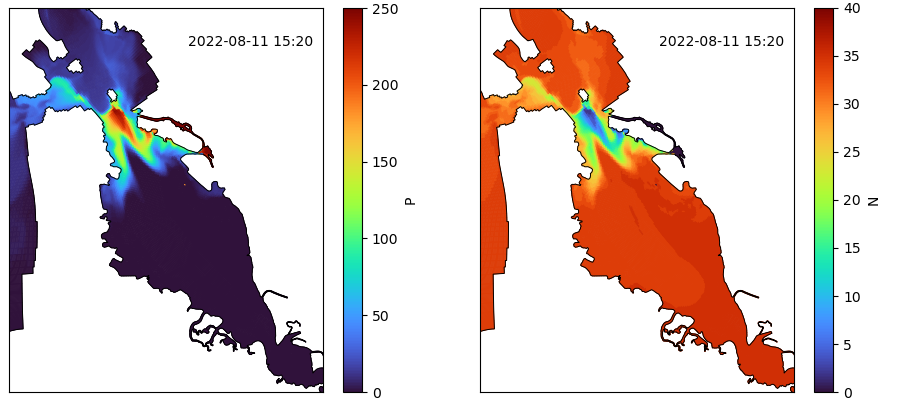

In [20]:
# Animation
fig,axs=plt.subplots(1,2,figsize=(9,4))
fig.subplots_adjust(left=0.01, right=0.97, top=0.98, bottom=0.02)
axP,axN = axs
caxs=[cbar.make_axes(ax)[0] for ax in axs]

for group in [0,1,2]:
    frame_dir=os.path.join(run_dir,f"frames_v00_{swim_speeds[group]}mpd")
    if not os.path.exists(frame_dir):
        os.makedirs(frame_dir)
    
    for ax in axs:
        ax.set_adjustable('datalim')
        ax.xaxis.set_visible(0)
        ax.yaxis.set_visible(0)    
    
    for tidx in range(ds.dims['time']):
        img_fn=os.path.join(frame_dir,"frame_%04d.png"%tidx)
        if os.path.exists(img_fn):
            continue
            
        result = solveNP(tidx=tidx,group=group, layer=15, kprod=0.35)
    
        axP.cla()
        axN.cla()
        
        kw=dict(lw=0.5,edgecolor='face', cmap='turbo')
        
        for ax,cax,plot in zip(axs,caxs,[
            dict(scal=result.P,label='P',clim=[0,250]),
            dict(scal=result.N,label='N',clim=[0,40])
        ]):
            ax.cla()
            cax.cla()
            
            ccoll=ds.grid.plot_cells( values=plot['scal'], ax=ax,**kw)
            ccoll.set_clim(plot['clim'])
            plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,ax=ax)
            plt.colorbar(ccoll,label=plot['label'],cax=cax)
            ax.axis((540604.0430344798, 585428.0850690929, 4144192.2487012795, 4198977.188965806))
            ax.text(0.57,0.9, utils.strftime(result.time), transform=ax.transAxes)
        fig.savefig(img_fn,dpi=100)

    movie_fn=os.path.join(frame_dir,"movie.mp4")

    # Compile to animation
    import subprocess
    if os.path.exists(movie_fn):
        os.unlink(movie_fn)
    subprocess.run(f"ffmpeg -framerate 10 -i {os.path.join(frame_dir,'frame_%04d.png')} "
                    "-c:v libx264 -preset slow -profile:v high -level:v 4.0 "
                   f"-pix_fmt yuv420p -crf 20 -r 10 {movie_fn}",
                   shell=True)


In [54]:
c

35119

In [57]:
# Thinking about distribution of insolation, and ways of approximating 
# synthesize time series of Rad
c=35119
Qsun=ds['Qsun'].isel(nFlowElem=c).values


In [62]:
depth = np.linspace(0,4,len(Qsun))
Kd=1.5
atten = np.exp(-depth*Kd)
rad_synth = Qsun * atten

Correction factor 0.400


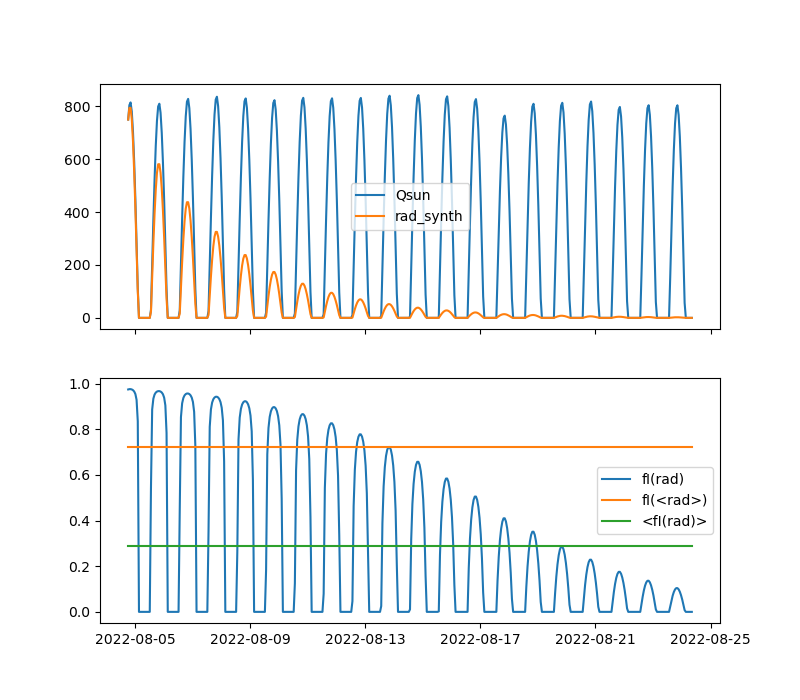

In [68]:
fig,(ax,ax_fI) = plt.subplots(2,1,sharex=True,figsize=(8,7))

ax.plot(ds.time, Qsun, label='Qsun')
ax.plot(ds.time, rad_synth, label='rad_synth')

Isat = 20.0
def fI(I):
    # 0.4
    return I/(I+Isat)

#def fI(I):
#    # 0.443
#    return I/Isat * np.exp(1-I/Isat)

ax_fI.plot(ds.time, fI(rad_synth), label='fI(rad)')
ax_fI.plot(ds.time, np.ones_like(rad_synth) * fI(rad_synth.mean()), label='fI(<rad>)')
ax_fI.plot(ds.time, np.ones_like(rad_synth) * fI(rad_synth).mean(), label='<fI(rad)>')

correction = fI(rad_synth).mean() / fI(rad_synth.mean())
print(f"Correction factor {correction:.3f}")

ax.legend()
ax_fI.legend()

In [302]:
Video(movie_fn) 